In [10]:

import pickle
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [13]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not",

    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not",

    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is",

    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",

    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would",

    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam",

    "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
    "must've": "must have",

    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock",

    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have",

    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is",

    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so as",

    "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would",

    "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have",

    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have",

    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are",

    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
    "what're": "what are",

    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is",

    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have",

    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have",

    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

In [22]:
class DataPreprocessor:
    def __init__(self, max_text_len=100, max_summary_len=15):
        self.max_text_len = max_text_len
        self.max_summary_len = max_summary_len
        self.x_tokenizer = None
        self.y_tokenizer = None
        # self.data = None

    def load_csv_from_google_drive(self, url, name):
        # Attempting to load a CSV file from a Google Drive link into a Pandas DataFrame.
        try:
            # Extracting file ID from the original URL to construct a direct download link.
            url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

            # Loading the CSV data from the constructed URL into a Pandas DataFrame.
            df = pd.read_csv(url, encoding='iso-8859-1')

            # Confirmation message upon successful loading of CSV data.
            print(f'{name} CSV loaded successfully.')

            # Returning the loaded DataFrame.
            return df

        except Exception as e:
            # Handling any exceptions that may occur during the process and printing the error message.
            print('Exception occurred: ', e)

    def load_data(self, ):
        print('Loading the summary dataset...')
        summary_df = self.load_csv_from_google_drive(
            "https://drive.google.com/file/d/1jjjtai8R0BTfTtfucbOQPCJTllXfV9Dy/view?usp=sharing", "Summary")

        print('\nLoading the raw dataset...')
        raw_df = self.load_csv_from_google_drive(
            "https://drive.google.com/file/d/1pt4kBnL0i-qtBKwgxBeTTKnkGINq8miE/view?usp=sharing", "Raw")

        # preprocessing steps
        raw_df_copy = raw_df.iloc[:, 0:2].copy()
        summary_df_copy = summary_df.iloc[:, 0:6].copy()
        summary_df_copy['text'] = summary_df_copy['author'].str.cat(summary_df_copy['date'].str.cat(
            summary_df_copy['read_more'].str.cat(summary_df_copy['text'].str.cat(summary_df_copy['ctext'], sep=" "),
                                                 sep=" "), sep=" "), sep=" ")

        data = pd.DataFrame()
        data['text'] = pd.concat([raw_df_copy['text'], summary_df_copy['text']], ignore_index=True)
        data['summary'] = pd.concat([raw_df_copy['headlines'], summary_df_copy['headlines']], ignore_index=True)

        self.data = data
        return self.data

    def replace_contractions(self, text):
        def replace(match):
            return contraction_mapping[match.group(0)]

        return re.sub("|".join(contraction_mapping.keys()), replace, text)

    def clean_text(self, _column):
        for row in _column:
            row = re.sub("(\\t)", ' ', str(row)).lower()  #remove escape charecters
            row = re.sub("(\\r)", ' ', str(row)).lower()
            row = re.sub("(\\n)", ' ', str(row)).lower()

            row = re.sub("(__+)", ' ', str(row)).lower()  #remove _ if it occors more than one time consecutively
            row = re.sub("(--+)", ' ', str(row)).lower()  #remove - if it occors more than one time consecutively
            row = re.sub("(~~+)", ' ', str(row)).lower()  #remove ~ if it occors more than one time consecutively
            row = re.sub("(\+\++)", ' ', str(row)).lower()  #remove + if it occors more than one time consecutively
            row = re.sub("(\.\.+)", ' ', str(row)).lower()  #remove . if it occors more than one time consecutively

            row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()  #remove <>()|&©ø"',;?~*!

            row = re.sub("(mailto:)", ' ', str(row)).lower()  #remove mailto:
            row = re.sub(r"(\\x9\d)", ' ', str(row)).lower()  #remove \x9* in text
            row = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower()  #replace INC nums to INC_NUM
            row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower()  #replace CM# and CHG# to CM_NUM

            row = re.sub("(\.\s+)", ' ', str(row)).lower()  #remove full stop at end of words(not between)
            row = re.sub("(\-\s+)", ' ', str(row)).lower()  #remove - at end of words(not between)
            row = re.sub("(\:\s+)", ' ', str(row)).lower()  #remove : at end of words(not between)

            row = re.sub("(\s+.\s+)", ' ', str(row)).lower()  #remove any single charecters hanging between 2 spaces

            #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
            try:
                url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
                repl_url = url.group(3)
                row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(row))
            except Exception:
                pass  #there might be emails with no url in them

            row = re.sub("(\s+)", ' ', str(row)).lower()  #remove multiple spaces

            yield re.sub("(\s+.\s+)", ' ', str(row)).lower()

    def split_data(self, data):
        x_train, x_val, y_train, y_val = train_test_split(data['text'], data['summary'], test_size=0.1, random_state=0,
                                                          shuffle=True)
        return x_train, x_val, y_train, y_val

In [23]:
preprocessor = DataPreprocessor()
df = preprocessor.load_data()

Loading the summary dataset...
Summary CSV loaded successfully.

Loading the raw dataset...
Raw CSV loaded successfully.


In [24]:
df.columns

Index(['text', 'summary'], dtype='object')

### Data Exploration

In [25]:
df.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED


In [1]:
df['text'][:10]

In [28]:
df['text'] = df['text'].apply(str).apply(preprocessor.replace_contractions)
df['summary'] = df['summary'].apply(str).apply(preprocessor.replace_contractions)

In [30]:
text_data = preprocessor.clean_text(df['text'])
summary_data = preprocessor.clean_text(df['summary'])

In [33]:
# from time import time
# import spacy

# # disabling Named Entity Recognition for speed
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# t = time()

# # Batch the data points into 5000 and run on all cores for faster preprocessing
# text_column = [str(doc) for doc in nlp.pipe(text_data, batch_size=5000, n_process=-1)]

# # Takes 7-8 mins
# print(f'Time to clean up everything: {round((time() - t) / 60, 2)} mins')

Time to clean up everything: 8.36 mins


In [34]:
# #Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


# t = time()

# # Batch the data points into 5000 and run on all cores for faster preprocessing
# summary_column = [
#     f'_START_ {str(doc)} _END_'
#     for doc in nlp.pipe(summary_data, batch_size=5000, n_process=-1)
# ]

# print(f'Time to clean up everything: {round((time() - t) / 60, 2)} mins')

Time to clean up everything: 4.35 mins


In [35]:
# text_column[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [36]:
# summary_column[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [37]:
df['cleaned_text'] = pd.Series(text_data)
df['cleaned_summary'] = pd.Series(summary_data)

In [38]:
df.head()

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,_START_ upgrad learner switches to career in ml al with 90% salary hike _END_
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,_START_ delhi techie wins free food from swiggy for one year on cred _END_
2,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...,New Zealand end Rohit Sharma-led India's 12-match winning streak,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,_START_ new zealand end rohit sharma-led india 12-match winning streak _END_
3,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...",Aegon life iTerm insurance plan helps customers save tax,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,_START_ aegon life iterm insurance plan helps customers save tax _END_
4,"Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I have known Hirani for many years...What if it is not true, the [#MeToo] movement will get derailed.""...","Have known Hirani for yrs, what if MeToo claims are not true: Sonam",speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said have known hirani for many years what if it is not true the #metoo movement will get derailed in the #met...,_START_ have known hirani for yrs what if metoo claims are not true sonam _END_


In [39]:
# df.to_csv('./cleaned_summary.csv')

In [40]:
# Select the Summaries and Text between max_len defined above

cleaned_text = np.array(df['cleaned_text'])
cleaned_summary = np.array(df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if (len(cleaned_summary[i].split()) <= preprocessor.max_summary_len and len(
            cleaned_text[i].split()) <= preprocessor.max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

new_df = pd.DataFrame({
    'text': short_text,
    'summary': short_summary
})

In [41]:
new_df.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,_START_ upgrad learner switches to career in ml al with 90% salary hike _END_
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,_START_ delhi techie wins free food from swiggy for one year on cred _END_
2,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,_START_ new zealand end rohit sharma-led india 12-match winning streak _END_
3,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,_START_ aegon life iterm insurance plan helps customers save tax _END_
4,speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said have known hirani for many years what if it is not true the #metoo movement will get derailed in the #met...,_START_ have known hirani for yrs what if metoo claims are not true sonam _END_


In [42]:
# Add sostok and eostok at 
new_df['summary'] = new_df['summary'].apply(lambda x: f'sostok {x} eostok')

In [44]:
new_df.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,sostok _START_ upgrad learner switches to career in ml al with 90% salary hike _END_ eostok
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,sostok _START_ delhi techie wins free food from swiggy for one year on cred _END_ eostok
2,new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five-match odi series india lost an international match under rohit sharma captaincy...,sostok _START_ new zealand end rohit sharma-led india 12-match winning streak _END_ eostok
3,with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹46 800^ on taxes the plan provides life cover up to the age of 100 years also custo...,sostok _START_ aegon life iterm insurance plan helps customers save tax _END_ eostok
4,speaking about the sexual harassment allegations against rajkumar hirani sonam kapoor said have known hirani for many years what if it is not true the #metoo movement will get derailed in the #met...,sostok _START_ have known hirani for yrs what if metoo claims are not true sonam _END_ eostok


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [104]:
x_tr, x_val, y_tr, y_val = preprocessor.split_data(new_df)

print(f'x_tr.shape: {x_tr.shape[0]}')
print(f'y_tr.shape: {y_tr.shape[0]}')
print(f'x_val.shape: {x_val.shape[0]}')
print(f'y_val.shape: {y_val.shape[0]}')

x_tr.shape: 88445
y_tr.shape: 88445
x_val.shape: 9828
y_val.shape: 9828


In [107]:
# Lets tokenize the text to get the vocab count

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [119]:
def find_text_frequency_count(tokenized_text, threshold):
    # Initialize count and frequency for words below the threshold
    count = 0
    frequency = 0

    # Calculate total count of words and their total frequency
    total_count = len(tokenized_text.word_counts)
    total_frequency = 0

    # Iterate through the word counts
    for value in tokenized_text.word_counts.values():
        total_frequency += value

        # Check if the word count is below the threshold
        if value < threshold:
            count += 1
            frequency += value

    # Return the results
    return count, total_count, frequency, total_frequency

In [110]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [127]:
count, total_count, frequency, total_frequency = find_text_frequency_count(x_tokenizer, 4)

print(f"Rare vocabulary words in train dataset: {round((count / total_count) * 100, 2)}%")
print(f"Rare words total Coverage in train dataset: {round((frequency / total_frequency) * 100, 2)}")

Rare vocabulary words in train dataset: 58.03%
Rare words total Coverage in train dataset: 1.34


In [128]:
count, total_count, frequency, total_frequency

(46073, 79401, 68955, 5137019)

In [121]:
def tokenize_text(_train, _validate, num_words):
    # prepare a tokenizer for reviews on training data
    _tokenizer = Tokenizer(num_words=num_words)
    _tokenizer.fit_on_texts(list(_train))

    # convert text sequences into integer sequences
    _train_seq = _tokenizer.texts_to_sequences(_train)
    _validate_seq = _tokenizer.texts_to_sequences(_validate)

    # padding zero upto maximum length
    _train = pad_sequences(
        _train_seq, maxlen=preprocessor.max_text_len, padding='post')
    _validate = pad_sequences(
        _validate_seq, maxlen=preprocessor.max_text_len, padding='post')

    vocab_size = len(_tokenizer.word_index) + 1

    return _train, _validate, vocab_size, _tokenizer

In [122]:
# prepare a tokenizer for reviews on training data
x_train, x_validate, x_vocab_size, x_tokenizer = tokenize_text(x_tr, x_val, total_count - count)

print(f"X vocabulary size is: {x_vocab_size}")

X vocabulary size is: 79402


In [123]:
count, total_count, frequency, total_frequency = find_text_frequency_count(y_tokenizer, threshold=6)

print(f"Rare vocabulary words in test dataset: {round((count / total_count) * 100, 2)}%")
print(f"Rare words total Coverage in test dataset: {round((frequency / total_frequency) * 100, 2)}")

Rare vocabulary words in test dataset: 66.31%
Rare words total Coverage in test dataset: 3.55


In [125]:
count, total_count, frequency, total_frequency

(22817, 34412, 42952, 1210275)

In [136]:
# prepare a tokenizer for summary on training data
y_train, y_validate, y_vocab_size, y_tokenizer = tokenize_text(y_tr, y_val, total_count - count)

print(f"Y vocabulary size is: {y_vocab_size}")

Y vocabulary size is: 34413


In [142]:
def remove_summary(_x_data, _y_data):
    # Create a boolean mask for rows with exactly two non-zero elements
    mask = np.array([np.count_nonzero(row) != 2 for row in _y_data])

    # Use the mask to filter out the rows
    _x_data = _x_data[mask]
    _y_data = _y_data[mask]

    return _x_data, _y_data

In [144]:
x_train, y_train = remove_summary(x_train, y_train)
x_validate, y_validate = remove_summary(x_validate, y_validate)

In [164]:
class Seq2SeqModel:
    def __init__(self, ):
        self.latent_dim = 300
        self.embedding_dim = 200
        self.batch_size = 256
        self.epochs = 40  # change to higher number 8 50
        self.model = None
        self.encoder_model = None
        self.decoder_model = None
        self.max_text_len = 100
        self.max_summary_len = 15

        self.encoder_inputs = None
        self.encoder_outputs = None
        self.decoder_inputs = None
        self.decoder_outputs = None
        self.dec_emb_layer = None
        self.decoder_lstm = None
        self.decoder_dense = None
        self.state_h = None
        self.state_c = None

    def create_model(self, x_vocab_size, y_vocab_size):
        # Encoder
        self.encoder_inputs = Input(shape=(self.max_text_len,))

        # embedding layer
        enc_emb_layer = Embedding(x_vocab_size, self.embedding_dim, trainable=True)(self.encoder_inputs)

        # encoder lstm 1
        encoder_lstm1 = LSTM(self.latent_dim, return_sequences=True, return_state=True, dropout=0.4,
                             recurrent_dropout=0.4)
        encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb_layer)

        # encoder lstm 2
        encoder_lstm2 = LSTM(self.latent_dim, return_sequences=True, return_state=True, dropout=0.4,
                             recurrent_dropout=0.4)
        encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

        # # encoder lstm 3
        # encoder_lstm3 = LSTM(self.latent_dim, return_state=True, return_sequences=True, dropout=0.4,
        #                      recurrent_dropout=0.4)
        # self.encoder_outputs, self.state_h, self.state_c = encoder_lstm3(encoder_output2)

        #encoder lstm 3
        encoder_lstm3 = LSTM(self.latent_dim, return_state=True, return_sequences=True, dropout=0.4,
                             recurrent_dropout=0.4)
        encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

        #encoder lstm 4
        encoder_lstm4 = LSTM(self.latent_dim, return_state=True, return_sequences=True, dropout=0.4,
                             recurrent_dropout=0.4)
        encoder_output4, state_h4, state_c4 = encoder_lstm4(encoder_output3)

        #encoder lstm 5
        encoder_lstm5 = LSTM(self.latent_dim, return_state=True, return_sequences=True, dropout=0.4,
                             recurrent_dropout=0.4)
        self.encoder_outputs, self.state_h, self.state_c = encoder_lstm4(encoder_output4)

        # Set up the decoder, using `encoder_states` as initial state.
        self.decoder_inputs = Input(shape=(None,))

        # embedding layer
        self.dec_emb_layer = Embedding(y_vocab_size, self.embedding_dim, trainable=True)
        dec_emb = self.dec_emb_layer(self.decoder_inputs)

        self.decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True, dropout=0.4,
                                 recurrent_dropout=0.2)
        self.decoder_outputs, decoder_fwd_state, decoder_back_state = self.decoder_lstm(dec_emb,
                                                                                        initial_state=[self.state_h,
                                                                                                       self.state_c])

        # dense layer
        self.decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # Define the model 
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

        self.model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

        self.get_model_summary()

        return self.model

    def encode_decoder(self, ):
        # Encode the input sequence to get the feature vector
        self.encoder_model = Model(inputs=self.encoder_inputs,
                                   outputs=[self.encoder_outputs, self.state_h, self.state_c])

        # Decoder setup
        # Below tensors will hold the states of the previous time step
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_hidden_state_input = Input(shape=(self.max_text_len, self.latent_dim))

        # Get the embeddings of the decoder sequence
        dec_emb2 = self.dec_emb_layer(self.decoder_inputs)

        # To predict the next word in the sequence, set the initial states to the states from the previous time step
        decoder_outputs2, state_h2, state_c2 = self.decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h,
                                                                                          decoder_state_input_c])

        # A dense softmax layer to generate prob dist. over the target vocabulary
        decoder_outputs2 = self.decoder_dense(decoder_outputs2)

        # Final decoder model
        self.decoder_model = Model(
            [self.decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
            [decoder_outputs2] + [state_h2, state_c2]
        )

    def decode_sequence(self, input_seq, target_word_index, reverse_target_word_index):
        # Encode the input as state vectors.
        e_out, e_h, e_c = self.encoder_model.predict(input_seq)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1))

        # Populate the first word of target sequence with the start word.
        target_seq[0, 0] = target_word_index['sostok']

        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + [e_out, e_h, e_c])

            # Sample a token
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = reverse_target_word_index[sampled_token_index]

            if (sampled_token != 'eostok'):
                decoded_sentence += f' {sampled_token}'

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (preprocessor.max_summary_len - 1)):
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update internal states
            e_h, e_c = h, c

        return decoded_sentence

    def generate_summary(self, input_seq, target_word_index, reverse_target_word_index):
        return ' '.join([reverse_target_word_index[i] for i in input_seq if
                         i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']])

    def generate_text(self, input_seq, reverse_source_word_index):
        return ' '.join([reverse_source_word_index[i] for i in input_seq if i != 0])

    def get_model_summary(self):
        return self.model.summary()

    def plot(self, history):
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

    def save_model(self):
        self.model.save('sequence_2_sequence.keras')
        self.encoder_model.save('encoder_model.keras')
        self.decoder_model.save('decoder_model.keras')
        print('Model saved successfully...')

    def train_model(self, _x_train, _y_train, _x_validate, _y_validate):
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

        return self.model.fit(
            [_x_train, _y_train[:, :-1]],
            _y_train.reshape(_y_train.shape[0], _y_train.shape[1], 1)[:, 1:],
            epochs=self.epochs,
            callbacks=[es],
            batch_size=self.batch_size,
            validation_data=(
                [_x_validate, _y_validate[:, :-1]],
                _y_validate.reshape(_y_validate.shape[0], _y_validate.shape[1], 1)[:, 1:]
            )
        )


In [152]:
s2s_model = Seq2SeqModel()

model = s2s_model.create_model(x_vocab_size, y_vocab_size)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 100, 200)  │ 15,880,400 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ [(None, 100,      │    601,200 │ embedding_10[0][… │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ [(None, 100,      │    721,200 │ lstm_20[0][0]     │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 200) │  6,882,600 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ [(None, 100,      │    721,200 │ lstm_21[0][0]     │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ [(None, None,     │    601,200 │ embedding_11[0][… │
│                     │ 300), (None,      │            │ lstm_22[0][1],    │
│                     │ 300), (None,      │            │ lstm_22[0][2]     │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, None,      │ 10,358,313 │ lstm_23[0][0]     │
│ (TimeDistributed)   │ 34413)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,766,113 (136.44 MB)

 Trainable params: 35,766,113 (136.44 MB)

 Non-trainable params: 0 (0.00 B)

**Start training the model with the data**

In [153]:
history = s2s_model.train_model(x_train, y_train, x_validate, y_validate)

Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - loss: 2.0659 - val_loss: 0.8235
Epoch 2/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - loss: 0.8303 - val_loss: 0.7916
Epoch 3/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - loss: 0.8058 - val_loss: 0.7862
Epoch 4/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - loss: 0.7997 - val_loss: 0.7826
Epoch 5/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - loss: 0.7973 - val_loss: 0.7808


**Visualize the model learning**

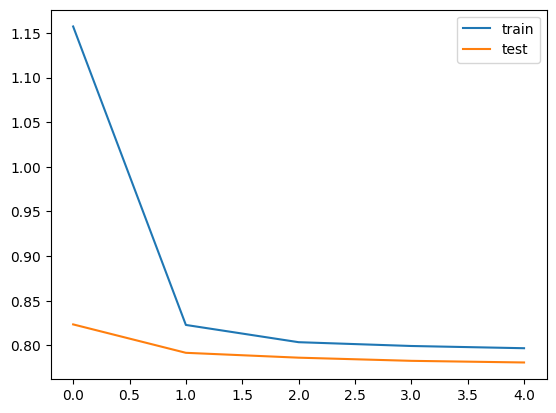

In [154]:
s2s_model.plot(history)

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [156]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [157]:
s2s_model.encode_decoder()

In [155]:
s2s_model.save_model()

Model saved successfully...


In [ ]:
model_components = {
    'x_tokenizer': x_tokenizer,
    'y_tokenizer': y_tokenizer,
    'reverse_source_word_index': reverse_source_word_index,
    'reverse_target_word_index': reverse_target_word_index,
    'target_word_index': target_word_index,
    'max_text_len': preprocessor.max_text_len,
    'max_summary_len': preprocessor.max_summary_len
}

with open('model_components.pkl', 'wb') as f:
    pickle.dump(model_components, f)
    print('Model components saved successfully...')

**Run the model over the data to see the results**

In [3]:
for i in range(1, 10):
    print("Review:", s2s_model.generate_text(x_tr[i], reverse_source_word_index))
    print("Original summary:", s2s_model.generate_summary(y_tr[i], target_word_index, reverse_target_word_index))
    print("Predicted summary:", s2s_model.decode_sequence(
        x_tr[i].reshape(1, preprocessor.max_text_len),
        target_word_index, reverse_target_word_index
    ))
    print("\n")